In [1]:
import numpy as np
import os
import sys
import time
import argparse
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
sys.path.insert(0,'/home/prisimage/tracker/py-MDNetST/modules')
from sample_generator import *
from data_prov import *
from model import *
from bbreg import *
from options import *
from gen_config import *
from sklearn.neighbors import NearestNeighbors

In [2]:
def set_optimizer(model, lr_base, lr_mult=opts['lr_mult'], momentum=opts['momentum'], w_decay=opts['w_decay']):
    params = model.get_learnable_params()
    param_list = []
    for k, p in params.iteritems():
        lr = lr_base
        for l, m in lr_mult.iteritems():
            if k.startswith(l):
                lr = lr_base * m
        param_list.append({'params': [p], 'lr':lr})
    optimizer = optim.SGD(param_list, lr = lr, momentum=momentum, weight_decay=w_decay)
    return optimizer

In [3]:
def show_bbox(image,bboxes):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    for i in range(len(bboxes)):
        rect = plt.Rectangle(tuple(bboxes[i,:2]),bboxes[i,2],bboxes[i,3], 
                             linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
        ax.add_patch(rect)
def show_result(image,bbox):
    dpi = 80.0
    figsize = (image.size[0]/dpi, image.size[1]/dpi)

    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im = ax.imshow(image, aspect=1)
    rect = plt.Rectangle(tuple(bbox[:2]),bbox[2],bbox[3], linewidth=1, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

In [4]:
def forward_samples(model, image, samples, out_layer='conv3'):
    model.eval()
    extractor = RegionExtractor(image, samples, opts['img_size'], opts['padding'], opts['batch_test'])
    for i, regions in enumerate(extractor):
        regions = Variable(regions)
        if opts['use_gpu']:
            regions = regions.cuda()
        feat = model(regions, out_layer=out_layer)
        if i==0:
            feats = feat.data.clone()
        else:
            feats = torch.cat((feats,feat.data.clone()),0)
    return feats

In [5]:
def train(model, criterion, optimizer, pos_feats, neg_feats, maxiter, in_layer='fc4'):
    model.train()
    
    batch_pos = opts['batch_pos']
    batch_neg = opts['batch_neg']
    batch_test = opts['batch_test']
    batch_neg_cand = max(opts['batch_neg_cand'], batch_neg)

    pos_idx = np.random.permutation(pos_feats.size(0))
    neg_idx = np.random.permutation(neg_feats.size(0))
    while(len(pos_idx) < batch_pos*maxiter):
        pos_idx = np.concatenate([pos_idx, np.random.permutation(pos_feats.size(0))])
    while(len(neg_idx) < batch_neg_cand*maxiter):
        neg_idx = np.concatenate([neg_idx, np.random.permutation(neg_feats.size(0))])
    pos_pointer = 0
    neg_pointer = 0

    for iter in range(maxiter):

        # select pos idx
        pos_next = pos_pointer+batch_pos
        pos_cur_idx = pos_idx[pos_pointer:pos_next]
        pos_cur_idx = pos_feats.new(pos_cur_idx).long()
        pos_pointer = pos_next

        # select neg idx
        neg_next = neg_pointer+batch_neg_cand
        neg_cur_idx = neg_idx[neg_pointer:neg_next]
        neg_cur_idx = neg_feats.new(neg_cur_idx).long()
        neg_pointer = neg_next

        # create batch
        batch_pos_feats = Variable(pos_feats.index_select(0, pos_cur_idx))
        batch_neg_feats = Variable(neg_feats.index_select(0, neg_cur_idx))

        # hard negative mining
        if batch_neg_cand > batch_neg:
            model.eval()
            for start in range(0,batch_neg_cand,batch_test):
                end = min(start+batch_test,batch_neg_cand)
                score = model(batch_neg_feats[start:end], in_layer=in_layer)
                if start==0:
                    neg_cand_score = score.data[:,1].clone()
                else:
                    neg_cand_score = torch.cat((neg_cand_score, score.data[:,1].clone()),0)

            _, top_idx = neg_cand_score.topk(batch_neg)
            batch_neg_feats = batch_neg_feats.index_select(0, Variable(top_idx))
            model.train()
        
        # forward
        pos_score = model(batch_pos_feats, in_layer=in_layer)
        neg_score = model(batch_neg_feats, in_layer=in_layer)
        
        # optimize
        loss = criterion(pos_score, neg_score)
        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), opts['grad_clip'])
        optimizer.step()

        #print "Iter %d, Loss %.4f" % (iter, loss.data[0])
#import cv2
def cvshow(img):
    cv2.imshow("Image",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

        
def stackList(featList):
    nframes = len(featList)
    for start in range(nframes):
        if start == 0:
            pos_data = featList[start].data.clone()
        else:
            pos_data = torch.cat((pos_data,featList[start].data.clone()),0)
    return pos_data

In [16]:
np.random.seed(123)
torch.manual_seed(456)
torch.cuda.manual_seed(789)
seq_home = '../dataset/OTB'
save_home = '../result_fig'
result_home = '../result'
        
seq_name = 'Basketball'
img_dir = os.path.join(seq_home, seq_name, 'img')
gt_path = os.path.join(seq_home, seq_name, 'groundtruth_rect.txt')

img_list = os.listdir(img_dir)
img_list.sort()
img_list = [os.path.join(img_dir,x) for x in img_list]

gt = np.loadtxt(gt_path,delimiter=',')
init_bbox = gt[0]
        
savefig_dir = os.path.join(save_home,seq_name)
result_dir = os.path.join(result_home,seq_name)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
result_path = os.path.join(result_dir,'result.json')
# get imglist,gt
target_bbox = np.array(init_bbox)
result = np.zeros((len(img_list),4))
result_bb = np.zeros((len(img_list),4))
result[0] = target_bbox
result_bb[0] = target_bbox
#init the first target box and result array
#os.environ['CUDA_VISIBLE_DEVICES'] = "1"
model = MDNet(opts['model_path'])
if opts['use_gpu']:
    model = model.cuda()
model.set_learnable_params(opts['ft_layers'])
#init model and set learnable layers

In [17]:
criterion = BinaryLoss()
init_optimizer = set_optimizer(model, opts['lr_init'])
update_optimizer = set_optimizer(model, opts['lr_update'])
image = Image.open(img_list[0]).convert('RGB')

In [18]:
bbreg_examples = gen_samples(SampleGenerator('uniform', image.size, 0.3, 1.5, 1.1),target_bbox, opts['n_bbreg'], opts['overlap_bbreg'], opts['scale_bbreg'])
bbreg_feats = forward_samples(model, image, bbreg_examples)
bbreg = BBRegressor(image.size)
bbreg.train(bbreg_feats, bbreg_examples, target_bbox)
#train bbreg

In [19]:
pos_examples = gen_samples(SampleGenerator('gaussian', image.size, 1.5, 1.2),target_bbox, opts['n_pos_init'], opts['overlap_pos_init'])
neg_examples = np.concatenate([
                    gen_samples(SampleGenerator('uniform', image.size, 1, 2, 1.1), 
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init']),
                    gen_samples(SampleGenerator('whole', image.size, 0, 1.2, 1.1),
                                target_bbox, opts['n_neg_init']//2, opts['overlap_neg_init'])])
neg_examples = np.random.permutation(neg_examples)

In [20]:
pos_feats = forward_samples(model, image, pos_examples)
neg_feats = forward_samples(model, image, neg_examples)
feat_dim = pos_feats.size(-1)
#get init pos/neg feats

In [21]:
train(model, criterion, init_optimizer,pos_feats, neg_feats, opts['maxiter_init'])

In [22]:
# Init sample generators
sample_generator = SampleGenerator('gaussian', image.size, opts['trans_f'], opts['scale_f'], valid=True)
pos_generator = SampleGenerator('gaussian', image.size, 0.1, 1.2)
neg_generator = SampleGenerator('uniform', image.size, 1.5, 1.2)

# Init pos/neg features for update
pos_feats_all = [pos_feats[:opts['n_pos_update']]]
neg_feats_all = [neg_feats[:opts['n_neg_update']]]

In [23]:
i=3
i=i+1
image = Image.open(img_list[i]).convert('RGB')
# Estimate target bbox
samples = gen_samples(sample_generator, target_bbox, opts['n_samples'])
i

4

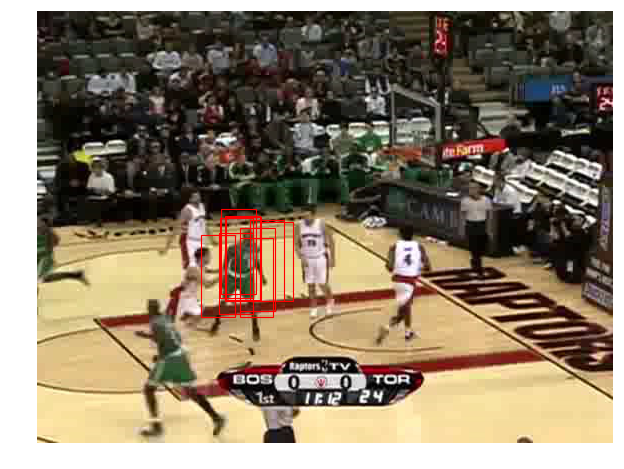

In [24]:
show_bbox(image,samples[:10,:])

In [70]:
sample_scores = forward_samples(model, image, samples, out_layer='fc6')
top_scores, top_idx = sample_scores[:,1].topk(5)
top_idx

tensor([244, 254, 168,  64, 121], device='cuda:0')

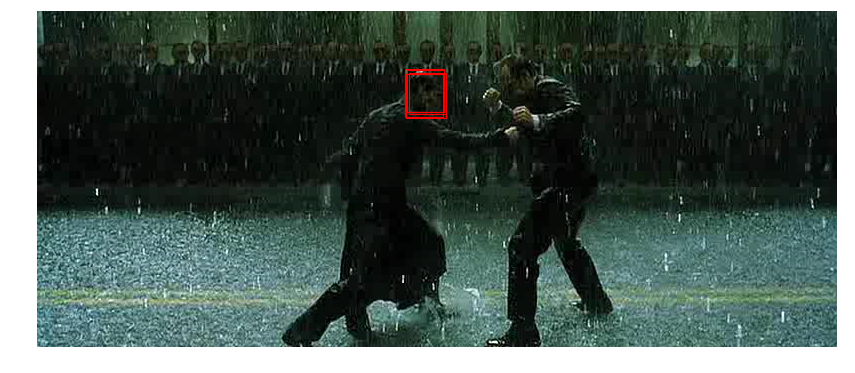

In [71]:
show_bbox(image,samples[top_idx,:])

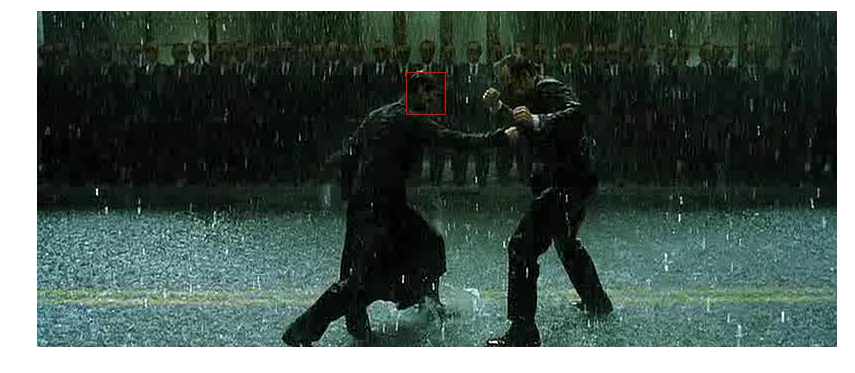

In [72]:
top_idx = top_idx.cpu().numpy()
target_score = top_scores.mean()
target_bbox = samples[top_idx].mean(axis=0)
show_result(image,target_bbox)

In [73]:
success = target_score > opts['success_thr']
success

tensor(1, device='cuda:0', dtype=torch.uint8)

In [243]:
if success and target_score > 1.0:
    sample_generator.set_trans_f(opts['trans_f'])
else:
    sample_generator.set_trans_f(opts['trans_f_expand'])

In [18]:
# Bbox regression
if success:
    bbreg_samples = samples[top_idx]
    bbreg_feats = forward_samples(model, image, bbreg_samples)
    bbreg_samples = bbreg.predict(bbreg_feats, bbreg_samples)
    bbreg_bbox = bbreg_samples.mean(axis=0)
else:
    bbreg_bbox = target_bbox
        
# Copy previous result at failure
if not success:
    target_bbox = result[i-1]
    bbreg_bbox = result_bb[i-1]
        
# Save result
result[i] = target_bbox
result_bb[i] = bbreg_bbox


In [245]:
if success:
    # Draw pos/neg samples
    pos_examples = gen_samples(pos_generator, target_bbox, 
                                opts['n_pos_update'],
                                opts['overlap_pos_update'])
    neg_examples = gen_samples(neg_generator, target_bbox, 
                                opts['n_neg_update'],
                                opts['overlap_neg_update'])

    # Extract pos/neg features
    pos_feats = forward_samples(model, image, pos_examples)
    neg_feats = forward_samples(model, image, neg_examples)
    pos_feats_all.append(pos_feats)
    neg_feats_all.append(neg_feats)
    if len(pos_feats_all) > opts['n_frames_long']:
        del pos_feats_all[0]
    if len(neg_feats_all) > opts['n_frames_short']:
        del neg_feats_all[0]


In [246]:
##test
pos_scores = forward_samples(model, image, pos_examples, out_layer='fc6')
pos_scores = pos_scores.cpu().numpy()
pos_examples[pos_scores[:,1]<0]

array([], shape=(0, 4), dtype=float32)

In [247]:
##test
neg_scores = forward_samples(model, image, neg_examples, out_layer='fc6')
neg_scores = neg_scores.cpu().numpy()
neg_examples[neg_scores[:,0]<0]

array([], shape=(0, 4), dtype=float32)

In [248]:
# Short term update
if not success:
    nframes = min(opts['n_frames_short'],len(pos_feats_all))
    pos_data = torch.stack(pos_feats_all[-nframes:],0).view(-1,feat_dim)
    neg_data = torch.stack(neg_feats_all,0).view(-1,feat_dim)
    train(model, criterion, update_optimizer, pos_data, neg_data, opts['maxiter_update'])
        
# Long term update
elif i % opts['long_interval'] == 0:
    pos_data = torch.stack(pos_feats_all,0).view(-1,feat_dim)
    neg_data = torch.stack(neg_feats_all,0).view(-1,feat_dim)
    train(model, criterion, update_optimizer, pos_data, neg_data, opts['maxiter_update'])
        

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


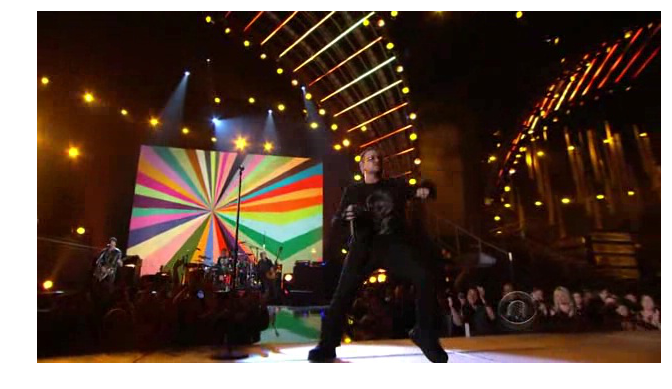

In [249]:
show_result(image,pos_examples[pos_scores[:,1]<0].mean(axis=0))

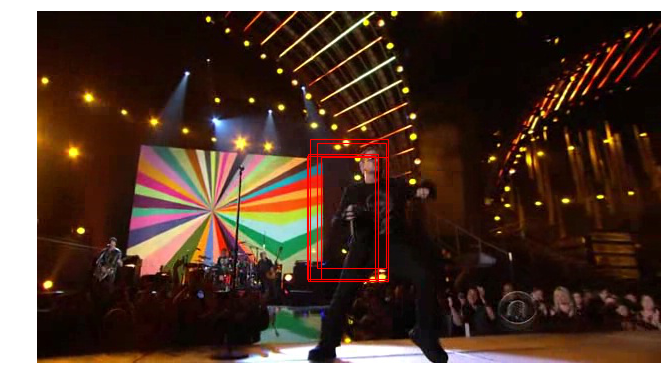

In [250]:
show_bbox(image,pos_examples[pos_scores[:,1]>1][:5,:])